## Comparing methods of calculating weighted regional and global means

### Import packages

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import esmlab

### Specify some test data

In [2]:
# This is a 4x5 I2000 control simulation with GSWP forcing (cycled 2000-2004) for 30 years
scr_dir = '/glade/scratch/kdagon/archive/'
case_name = 'hydro_ensemble_default_params'
file_path = scr_dir+case_name+'/lnd/hist/'
print(file_path)

/glade/scratch/kdagon/archive/hydro_ensemble_default_params/lnd/hist/


### Specify model year, read in data

In [3]:
model_yr = 30

In [4]:
fils_in = xr.open_mfdataset(file_path+'*.clm2.h0.00'+str(model_yr)+'*.nc', combine='by_coords')
fils_in

<xarray.Dataset>
Dimensions:                 (cft: 2, glc_nec: 10, hist_interval: 2, lat: 46, levdcmp: 1, levgrnd: 25, levlak: 10, levsoi: 20, lon: 72, ltype: 9, natpft: 15, nvegwcs: 4, time: 12)
Coordinates:
  * levgrnd                 (levgrnd) float32 0.01 0.04 ... 28.870724 41.998436
  * levdcmp                 (levdcmp) float32 1.0
  * lat                     (lat) float32 -90.0 -86.0 -82.0 ... 82.0 86.0 90.0
  * lon                     (lon) float32 0.0 5.0 10.0 ... 345.0 350.0 355.0
  * levlak                  (levlak) float32 0.05 0.6 2.1 ... 25.6 34.325 44.775
  * time                    (time) object 0030-02-01 00:00:00 ... 0031-01-01 00:00:00
Dimensions without coordinates: cft, glc_nec, hist_interval, levsoi, ltype, natpft, nvegwcs
Data variables:
    mcdate                  (time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    mcsec                   (time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    mdcur                   (time) int32 dask.array<chunksiz

### Pull out a specific output variable

In [5]:
TSA = fils_in.TSA # this is now a DataArray of 2m air temperature
TSA

<xarray.DataArray 'TSA' (time: 12, lat: 46, lon: 72)>
dask.array<concatenate, shape=(12, 46, 72), dtype=float32, chunksize=(1, 46, 72), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -86.0 -82.0 -78.0 -74.0 ... 78.0 82.0 86.0 90.0
  * lon      (lon) float32 0.0 5.0 10.0 15.0 20.0 ... 340.0 345.0 350.0 355.0
  * time     (time) object 0030-02-01 00:00:00 ... 0031-01-01 00:00:00
Attributes:
    long_name:     2m air temperature
    units:         K
    cell_methods:  time: mean

### Annual mean to make calculations simpler

/glade/work/kdagon/miniconda/envs/CMIP6-201910/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


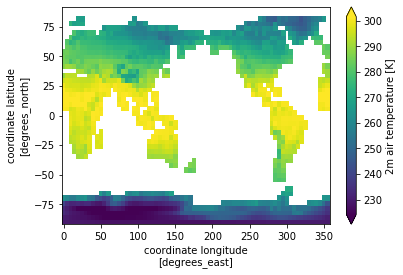

In [6]:
TSA_amean = TSA.mean(dim='time')
TSA_amean.plot(robust=True);
# Not sure why the true_divide warning shows up...missing/fillvalues over the ocean?

### Get gridcell areas and landfrac

In [7]:
# Just pull the first time index since these are time-invariant fields
area = fils_in.area[0]
landfrac = fils_in.landfrac[0]

### Calculate area weights

In [8]:
arwt = area * landfrac

In [9]:
# re-assign long_name attribute
arwt.attrs['long_name'] = 'grid cell areas multiplied by landfrac'

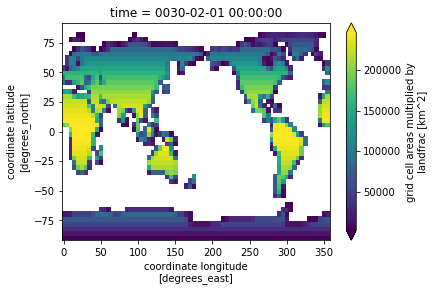

In [10]:
# quick plot of area weights
arwt.plot(robust=True);

### Normalize arwt: 2 methods!

In [11]:
# normalize by sum of area weights
arwt_norm_sum = arwt/arwt.sum()
arwt_norm_sum.attrs['long_name'] = 'area weights normalized by sum'
arwt_norm_sum.attrs['units'] = ''
arwt_norm_sum

<xarray.DataArray (lat: 46, lon: 72)>
dask.array<truediv, shape=(46, 72), dtype=float32, chunksize=(46, 72), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -86.0 -82.0 -78.0 -74.0 ... 78.0 82.0 86.0 90.0
  * lon      (lon) float32 0.0 5.0 10.0 15.0 20.0 ... 340.0 345.0 350.0 355.0
    time     object 0030-02-01 00:00:00
Attributes:
    long_name:  area weights normalized by sum
    units:      

In [12]:
# normalize by maximum of area weights
arwt_norm_max = arwt/arwt.max()
arwt_norm_max.attrs['long_name'] = 'area weights normalized by max'
arwt_norm_max.attrs['units'] = ''
arwt_norm_max

<xarray.DataArray (lat: 46, lon: 72)>
dask.array<truediv, shape=(46, 72), dtype=float32, chunksize=(46, 72), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -86.0 -82.0 -78.0 -74.0 ... 78.0 82.0 86.0 90.0
  * lon      (lon) float32 0.0 5.0 10.0 15.0 20.0 ... 340.0 345.0 350.0 355.0
    time     object 0030-02-01 00:00:00
Attributes:
    long_name:  area weights normalized by max
    units:      

## 1. Global Means

### Start with both methods of normalized arwt

Needed some help getting scalar output from 2D weighted means function: https://github.com/NCAR/esmlab/issues/28 \
This is the purpose of `.load().values`

In [13]:
TSA_glob_mean_arwt_sum = esmlab.statistics.weighted_mean(TSA_amean, dim=['lat','lon'], weights=arwt_norm_sum).load().values
TSA_glob_mean_arwt_sum

/glade/work/kdagon/miniconda/envs/CMIP6-201910/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


array(283.07242, dtype=float32)

In [14]:
TSA_glob_mean_arwt_max = esmlab.statistics.weighted_mean(TSA_amean, dim=['lat','lon'], weights=arwt_norm_max).load().values
TSA_glob_mean_arwt_max

/glade/work/kdagon/miniconda/envs/CMIP6-201910/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


array(283.07245, dtype=float32)

### Generate weights using cosine of latitudes

In [15]:
lats = fils_in.lat

In [16]:
# np.cos expects input in radians
cwt = np.cos(lats * np.pi / 180.)

In [17]:
# NOTE: this doesn't account for landfrac...but how to do that when cwt is indexed only by latitude?
TSA_glob_mean_cwt = esmlab.statistics.weighted_mean(TSA_amean, dim=['lat'], weights=cwt).mean().values
TSA_glob_mean_cwt

/glade/work/kdagon/miniconda/envs/CMIP6-201910/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


array(279.76453, dtype=float32)

### TO DO: Generate Gaussian weights, similar to CAM output variable

Most straightforward solution is probably to figure out how to write or convert the NCL `gaus` function to python:\
https://www.ncl.ucar.edu/Document/Functions/Built-in/gaus.shtml

### Calculate the area element in spherical coordinates

This is based on the python tutorial xarray notebook:\
https://github.com/ncar-hackathons/hands-on-examples/blob/master/scientific-computing/xarray.ipynb

The [area element for lat-lon coordinates](https://en.wikipedia.org/wiki/Spherical_coordinate_system#Integration_and_differentiation_in_spherical_coordinates) is

$$ \delta A = R^2 \delta \phi \delta \lambda \cos(\phi) $$

where $\phi$ is latitude, $\delta \phi$ is the spacing of the points in latitude, $\delta \lambda$ is the spacing of the points in longitude, and $R$ is Earth's radius. (In this formula, $\phi$ and $\lambda$ are measured in radians.) Let's use xarray to create the weight factor.

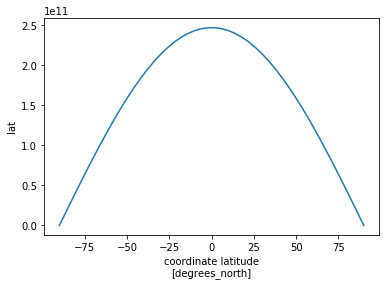

In [18]:
R = 6.37e6
# we know already that the spacing of the points is 4 degrees latitude, 5 degrees longitude
dϕ = np.deg2rad(4.)
dλ = np.deg2rad(5.)
dA = R**2 * dϕ * dλ * np.cos(np.deg2rad(lats))
dA.plot()

In [19]:
dA.where(TSA_amean.notnull())

<xarray.DataArray 'lat' (lat: 46, lon: 72)>
dask.array<where, shape=(46, 72), dtype=float32, chunksize=(46, 72), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -86.0 -82.0 -78.0 -74.0 ... 78.0 82.0 86.0 90.0
  * lon      (lon) float32 0.0 5.0 10.0 15.0 20.0 ... 340.0 345.0 350.0 355.0

/glade/work/kdagon/miniconda/envs/CMIP6-201910/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


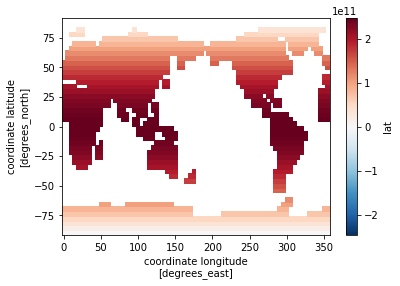

In [20]:
pixel_area = dA.where(TSA_amean.notnull())
pixel_area.plot(robust=True);
# why are there negative values in the colorbar?

In [21]:
# NOTE: this also doesn't account for landfrac...
total_land_area = pixel_area.sum(dim=['lat', 'lon'])
TSA_glob_mean_ae = ((TSA_amean * pixel_area).sum(dim=['lat', 'lon']) / total_land_area).values
TSA_glob_mean_ae

/glade/work/kdagon/miniconda/envs/CMIP6-201910/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


array(284.4086, dtype=float32)

Try again, accounting for landfrac

/glade/work/kdagon/miniconda/envs/CMIP6-201910/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


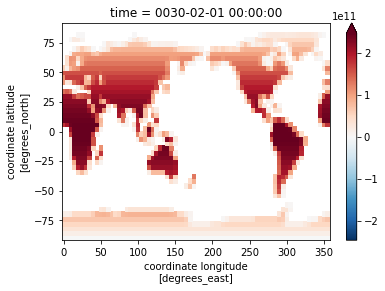

In [22]:
pixel_area_lf = dA.where(TSA_amean.notnull())*landfrac
pixel_area_lf.plot(robust=True);

In [23]:
total_land_area_lf = pixel_area_lf.sum(dim=['lat', 'lon'])
TSA_glob_mean_ae_lf = ((TSA_amean * pixel_area_lf).sum(dim=['lat', 'lon']) / total_land_area_lf).values
TSA_glob_mean_ae_lf

/glade/work/kdagon/miniconda/envs/CMIP6-201910/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


array(283.12924, dtype=float32)

Now the result is closer to arwt methods

### NCL-based weighted mean function

Via GeoCAT: https://geocat-examples.readthedocs.io/en/latest/gallery/XY/NCL_xy_18.html#ncl-based-weighted-mean-function 

This function is equivalent to esmlab weighted mean, and result will vary similarly depending on choice of weights

In [24]:
def horizontal_weighted_mean(var, wgts):
    return (var * wgts).sum(dim=['lat', 'lon']) / wgts.sum(dim=['lat', 'lon'])

In [25]:
TSA_glob_mean_geocat_sum = horizontal_weighted_mean(TSA_amean, arwt_norm_sum).values
TSA_glob_mean_geocat_sum

/glade/work/kdagon/miniconda/envs/CMIP6-201910/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


array(283.07242, dtype=float32)

In [26]:
TSA_glob_mean_geocat_max = horizontal_weighted_mean(TSA_amean, arwt_norm_max).values
TSA_glob_mean_geocat_max

/glade/work/kdagon/miniconda/envs/CMIP6-201910/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


array(283.07245, dtype=float32)

### Plot results so far

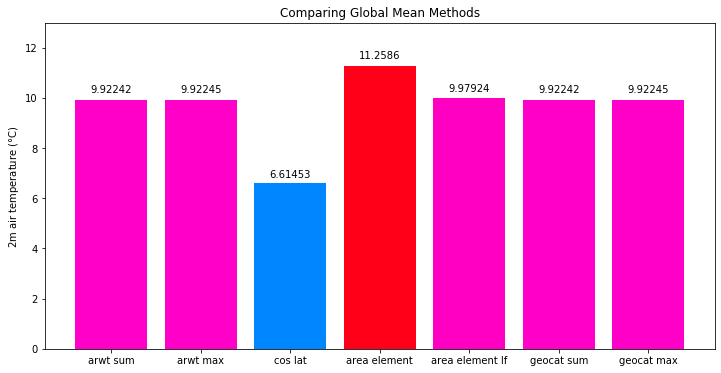

In [27]:
fig, ax = plt.subplots(figsize=(12,6))
means = [TSA_glob_mean_arwt_sum, TSA_glob_mean_arwt_max, TSA_glob_mean_cwt, TSA_glob_mean_ae, TSA_glob_mean_ae_lf, TSA_glob_mean_geocat_sum, TSA_glob_mean_geocat_max]
x = np.arange(len(means))
means_c = [m - 273.15 for m in means]

# color code bars based on value - though hard to distinguish close values
from matplotlib import cm
color_vals = np.array(means_c)
colors = cm.hsv(color_vals / float(max(color_vals)))

bar_plot = plt.bar(x,means_c,color = colors)
plt.title("Comparing Global Mean Methods")
plt.ylabel("2m air temperature ($\degree$C)")
plt.xticks(x, ('arwt sum','arwt max','cos lat', 'area element', 'area element lf', 'geocat sum', 'geocat max'))

# add text labels
labels_plot = [round(m, 5) for m in means_c] # round to 4 decimal places
def autolabel(rects):
    for idx,rect in enumerate(bar_plot):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.02*height,
                labels_plot[idx],
                ha='center', va='bottom', rotation=0)

autolabel(bar_plot)

plt.ylim(0,13);

Sidenote: global mean TSA values may seem low, but these are land only averages

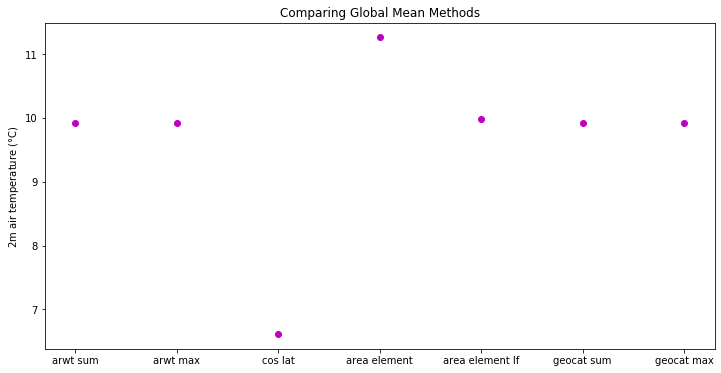

In [28]:
# Another way to plot?
plt.figure(figsize=(12,6))
plt.plot(means_c, 'mo')
plt.title("Comparing Global Mean Methods")
plt.ylabel("2m air temperature ($\degree$C)")
plt.xticks(x, ('arwt sum','arwt max','cos lat', 'area element', 'area element lf', 'geocat sum', 'geocat max'));

## 2. Regional Means

### Define regional box

In [55]:
# Most of CONUS
lat_min = 30
lat_max = 50
lon_min = 230
lon_max = 290

In [56]:
TSA_amean_US = TSA_amean.sel(lat=slice(lat_min,lat_max), lon=slice(lon_min,lon_max))
TSA_amean_US

<xarray.DataArray 'TSA' (lat: 6, lon: 13)>
dask.array<getitem, shape=(6, 13), dtype=float32, chunksize=(6, 13), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 30.0 34.0 38.0 42.0 46.0 50.0
  * lon      (lon) float32 230.0 235.0 240.0 245.0 ... 275.0 280.0 285.0 290.0
Attributes:
    long_name:     2m air temperature
    units:         K
    cell_methods:  time: mean

### arwt (2 methods)

In [57]:
TSA_US_mean_arwt_sum = esmlab.statistics.weighted_mean(TSA_amean_US, dim=['lat','lon'], weights=arwt_norm_sum.sel(lat=slice(lat_min,lat_max),lon=slice(lon_min,lon_max))).load().values
TSA_US_mean_arwt_sum

/glade/work/kdagon/miniconda/envs/CMIP6-201910/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


array(283.41443, dtype=float32)

In [58]:
TSA_US_mean_arwt_max = esmlab.statistics.weighted_mean(TSA_amean_US, dim=['lat','lon'], weights=arwt_norm_max.sel(lat=slice(lat_min,lat_max),lon=slice(lon_min,lon_max))).load().values
TSA_US_mean_arwt_max

/glade/work/kdagon/miniconda/envs/CMIP6-201910/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


array(283.4144, dtype=float32)

### cwt

In [78]:
TSA_US_mean_cwt = esmlab.statistics.weighted_mean(TSA_amean_US, dim=['lat'], weights=cwt.sel(lat=slice(lat_min,lat_max))).mean().values
TSA_US_mean_cwt

/glade/work/kdagon/miniconda/envs/CMIP6-201910/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


array(284.19653, dtype=float32)

### area element

/glade/work/kdagon/miniconda/envs/CMIP6-201910/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


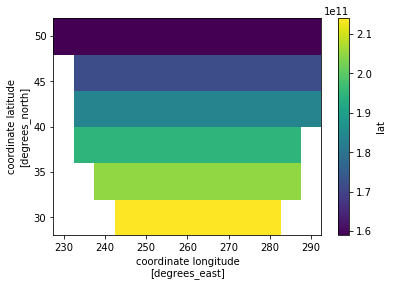

In [65]:
CONUS_pixel_area = pixel_area.sel(lat=slice(lat_min,lat_max),lon=slice(lon_min,lon_max))
CONUS_pixel_area.plot(robust=True)

In [70]:
CONUS_land_area = CONUS_pixel_area.sum(dim=['lat', 'lon'])

In [71]:
TSA_US_mean_ae = ((TSA_amean_US * CONUS_pixel_area).sum(dim=['lat', 'lon']) / CONUS_land_area).values
TSA_US_mean_ae

/glade/work/kdagon/miniconda/envs/CMIP6-201910/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


array(284.4153, dtype=float32)

### area element with landfrac

/glade/work/kdagon/miniconda/envs/CMIP6-201910/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


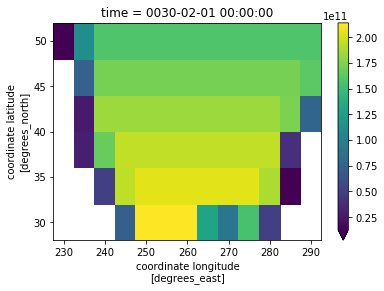

In [73]:
CONUS_pixel_area_lf = CONUS_pixel_area*landfrac.sel(lat=slice(lat_min,lat_max),lon=slice(lon_min,lon_max))
CONUS_pixel_area_lf.plot(robust=True);

In [74]:
CONUS_land_area_lf = CONUS_pixel_area_lf.sum(dim=['lat', 'lon'])
TSA_US_mean_ae_lf = ((TSA_amean_US * CONUS_pixel_area_lf).sum(dim=['lat', 'lon']) / CONUS_land_area_lf).values
TSA_US_mean_ae_lf

/glade/work/kdagon/miniconda/envs/CMIP6-201910/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


array(283.4145, dtype=float32)

### GeoCAT function

In [75]:
TSA_US_mean_geocat_sum = horizontal_weighted_mean(TSA_amean_US, arwt_norm_sum.sel(lat=slice(lat_min,lat_max),lon=slice(lon_min,lon_max))).values
TSA_US_mean_geocat_sum

/glade/work/kdagon/miniconda/envs/CMIP6-201910/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


array(283.41443, dtype=float32)

In [76]:
TSA_US_mean_geocat_max = horizontal_weighted_mean(TSA_amean_US, arwt_norm_max.sel(lat=slice(lat_min,lat_max),lon=slice(lon_min,lon_max))).values
TSA_US_mean_geocat_max

/glade/work/kdagon/miniconda/envs/CMIP6-201910/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


array(283.4144, dtype=float32)

### Plot results

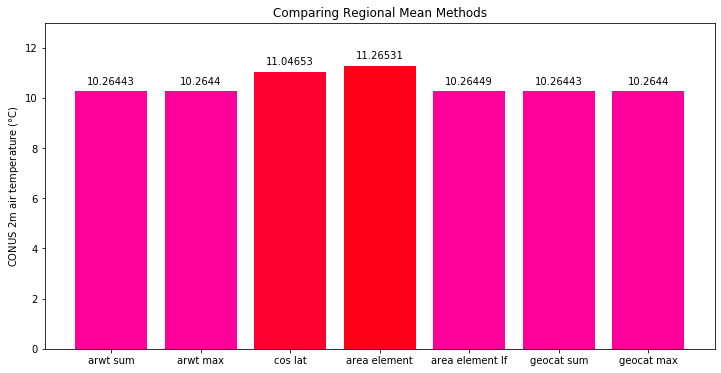

In [77]:
fig, ax = plt.subplots(figsize=(12,6))
means = [TSA_US_mean_arwt_sum, TSA_US_mean_arwt_max, TSA_US_mean_cwt, TSA_US_mean_ae, TSA_US_mean_ae_lf, TSA_US_mean_geocat_sum, TSA_US_mean_geocat_max]
x = np.arange(len(means))
means_c = [m - 273.15 for m in means]

# color code bars based on value - though hard to distinguish close values
from matplotlib import cm
color_vals = np.array(means_c)
colors = cm.hsv(color_vals / float(max(color_vals)))

bar_plot = plt.bar(x,means_c,color = colors)
plt.title("Comparing Regional Mean Methods")
plt.ylabel("CONUS 2m air temperature ($\degree$C)")
plt.xticks(x, ('arwt sum','arwt max','cos lat', 'area element', 'area element lf', 'geocat sum', 'geocat max'))

# add text labels
labels_plot = [round(m, 5) for m in means_c] # round to 4 decimal places
def autolabel(rects):
    for idx,rect in enumerate(bar_plot):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.02*height,
                labels_plot[idx],
                ha='center', va='bottom', rotation=0)

autolabel(bar_plot)

plt.ylim(0,13);

Interesting, this time cos lat biases high, versus globally it biases low\
Everything else is similar to global relationships